This jupyter notebook contains the code written for the module 3 (V2.1) project covering classification models. The dataset used, 'flights.csv', contains details about US domestic flights for large air carriers during 2015. The data was originally collected and published by the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics. Weather data from 2015 was pulled using an api and was used in conjuction with flights.csv to predict whether flights were delayed leaving IAH in Houston. Delayed is defined by a departure 15 minutes or greater than the original departure time. 

This information will help consumers book connecting flights from IAH. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_tree
import itertools
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

IAH = pd.read_csv('flight_filtered.csv')
IAH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146622 entries, 0 to 146621
Data columns (total 32 columns):
Unnamed: 0             146622 non-null int64
YEAR                   146622 non-null int64
MONTH                  146622 non-null int64
DAY                    146622 non-null int64
DAY_OF_WEEK            146622 non-null int64
AIRLINE                146622 non-null object
FLIGHT_NUMBER          146622 non-null int64
TAIL_NUMBER            146017 non-null object
ORIGIN_AIRPORT         146622 non-null object
DESTINATION_AIRPORT    146622 non-null object
SCHEDULED_DEPARTURE    146622 non-null int64
DEPARTURE_TIME         144660 non-null float64
DEPARTURE_DELAY        144660 non-null float64
TAXI_OUT               144528 non-null float64
WHEELS_OFF             144528 non-null float64
SCHEDULED_TIME         146622 non-null float64
ELAPSED_TIME           144019 non-null float64
AIR_TIME               144019 non-null float64
DISTANCE               146622 non-null int64
WHEELS_ON       

### Adding column 'DELAYED' as a binary classifier (15+/= 'DEPARTURE_DELAY' == True)

In [3]:
IAH.loc[IAH['DEPARTURE_DELAY'] >= 15, 'DELAYED'] = 1
IAH.loc[IAH['DEPARTURE_DELAY'] < 15, 'DELAYED'] = 0
#IAH.info()
IAH['DELAYED'].sum()

30873.0

### Dropping all cancelled flights rows, dropping columns 'CANCELLED' and 'CANCELLATON_REASON'

In [4]:
IAH['CANCELLED'].unique()
IAH = IAH.loc[IAH['CANCELLED'] == 0].copy()
IAH['CANCELLED'].unique()
IAH = IAH.drop(['CANCELLED', 'CANCELLATION_REASON'], axis = 1)
#IAH.info()

### Removing columns that will cause data leakage (columns dependent on the classification label)

In [5]:
IAH = IAH.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis = 1).copy()
#IAH.info()

### Find all nan values (473 rows)
### All columns containing nan values will not affect departure delays because they are all statistics derived after takeoff
### Remove all rows containing nan values

In [6]:
#print(IAH.isnull().sum())
IAH = IAH.dropna().copy()
#print(IAH.isnull().sum())
#print(IAH.info())

### Binning departure time by hours (rounding down)

### Do I want to do better form of binning?

In [7]:
IAH['DEPART_TIME_BIN'] = np.floor(IAH['SCHEDULED_DEPARTURE']/100)*100
IAH['DEPART_TIME_BIN'] = IAH['DEPART_TIME_BIN'].astype(int)
IAH.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DIVERTED,DELAYED,DEPART_TIME_BIN
74,2015,1,1,4,AA,89,N3KVAA,IAH,MIA,520,...,137.0,111.0,964,928.0,7.0,841,935.0,0,1.0,500
200,2015,1,1,4,US,410,N765US,IAH,PHX,600,...,173.0,155.0,1009,742.0,4.0,750,746.0,0,0.0,600
300,2015,1,1,4,F9,1057,N919FR,IAH,SFO,600,...,262.0,237.0,1635,805.0,9.0,820,814.0,0,0.0,600
547,2015,1,1,4,NK,200,N530NK,IAH,ORD,623,...,140.0,115.0,925,830.0,10.0,855,840.0,0,0.0,600
837,2015,1,1,4,US,1961,N566UW,IAH,CLT,700,...,137.0,105.0,912,953.0,20.0,1022,1013.0,0,0.0,700


### API calls for every day of 2015, for weather at every hour, at IAH, saving as CSV

In [8]:
# days_df = IAH[['MONTH', 'DAY', 'YEAR']].copy()
# days_df = days_df.drop_duplicates()
# days_df = days_df.reset_index(drop = True)
# days_df['DATE_FORMAT'] = pd.to_datetime((days_df.YEAR*10000+days_df.MONTH*100+days_df.DAY).apply(str),format='%Y%m%d')
# date_series = days_df['DATE_FORMAT']
# days_df.head()

# for date in date_series:
#     date_string = 'T'.join(str(date).split(' '))
#     print(date_string)
#     response = requests.get('https://api.darksky.net/forecast/6faf9a5452b99be192c9cf383956da1b/29.9804989,-95.3396578,' + date_string)
#     weather_dict = response.json()
#     hourly = weather_dict['hourly']['data']
#     hourly_weather_per_day = pd.DataFrame(hourly)
#     if date_series[0] == date:
#         year_of_hourly_weather = pd.DataFrame(hourly_weather_per_day)
#     else:   
#         year_of_hourly_weather = year_of_hourly_weather.append(hourly_weather_per_day)

# year_of_hourly_weather.to_csv('weather_2015_raw.csv')



# # commenting out to not re run

### converting the weather csv file to a dataframe and cleaning the data

In [9]:
# conferting csv file to dataframe
year_of_hourly_weather = pd.read_csv('weather_2015_raw.csv')
year_of_hourly_weather.info()

# dropping unnecessary columns
year_of_hourly_weather = year_of_hourly_weather.drop(['Unnamed: 0', 'precipType'], axis = 1)

# checking for and correcting all null values
# if precipAccumulation = nan, set equal to zero
# if windGust = nan, set equal to windSpeed
# how: locate rows where windGust is nan, pull values from windGust column. Set those values equal to windSpeed where windGust equaled nan. 
# if windBearing = nan, set equal to zero

#print(year_of_hourly_weather.isnull().sum())
year_of_hourly_weather['precipAccumulation'].fillna(0, inplace = True)
year_of_hourly_weather.loc[year_of_hourly_weather['windGust'].isna(), 'windGust'] = year_of_hourly_weather.loc[year_of_hourly_weather['windGust'].isna(), 'windSpeed']
year_of_hourly_weather = year_of_hourly_weather.fillna(0)
#print(year_of_hourly_weather.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 19 columns):
Unnamed: 0             8016 non-null int64
apparentTemperature    8016 non-null float64
cloudCover             8016 non-null float64
dewPoint               8016 non-null float64
humidity               8016 non-null float64
icon                   8016 non-null object
precipAccumulation     2 non-null float64
precipIntensity        8016 non-null float64
precipProbability      8016 non-null float64
precipType             1818 non-null object
pressure               8016 non-null float64
summary                8016 non-null object
temperature            8016 non-null float64
time                   8016 non-null int64
uvIndex                8016 non-null int64
visibility             8016 non-null float64
windBearing            8003 non-null float64
windGust               8006 non-null float64
windSpeed              8016 non-null float64
dtypes: float64(13), int64(3), object(3)
memory us

### saving clean data to a new csv

In [10]:
# year_of_hourly_weather.to_csv('clean_IAH_weather.csv')

# # commenting out to not re run

### converting EPOCH time to datetime

In [11]:
year_of_hourly_weather['DATETIME'] = pd.to_datetime(year_of_hourly_weather['time'], unit = 's')
year_of_hourly_weather.head()


,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,DATETIME
0,39.74,1.0,34.83,0.71,cloudy,0.0,0.0000,0.00,1027.8,Overcast,43.61,1420092000,0,9.997,39.0,6.71,6.54,2015-01-01 06:00:00
1,41.03,1.0,34.85,0.71,cloudy,0.0,0.0000,0.00,1027.4,Overcast,43.65,1420095600,0,9.997,31.0,6.04,4.63,2015-01-01 07:00:00
2,40.60,1.0,36.05,0.77,rain,0.0,0.0069,0.68,1026.8,Drizzle,42.93,1420099200,0,9.976,30.0,4.34,4.11,2015-01-01 08:00:00
3,39.49,1.0,35.77,0.76,cloudy,0.0,0.0012,0.14,1026.1,Overcast,42.86,1420102800,0,9.997,40.0,5.49,5.49,2015-01-01 09:00:00
4,38.29,1.0,35.73,0.77,cloudy,0.0,0.0005,0.13,1025.2,Overcast,42.46,1420106400,0,9.997,21.0,6.65,6.65,2015-01-01 10:00:00


### converting DAY/MONTH/YEAR columns in IAH to datetime

In [12]:
IAH['DATE_FORMAT'] = pd.to_datetime((IAH.YEAR*10000+IAH.MONTH*100+IAH.DAY).apply(str),format='%Y%m%d')
IAH['DATETIME'] = IAH['DATE_FORMAT'] + pd.to_timedelta(IAH['DEPART_TIME_BIN']/100, unit = 'h')
# IAH.head()
# IAH.info()

### joining IAH and year_of_hourly_weather dataframe on datetime columns

In [13]:
# one API call was not made, deleting that single row

IAH_with_WEATHER = IAH.set_index('DATETIME').join(year_of_hourly_weather.set_index('DATETIME')).copy()
IAH_with_WEATHER.reset_index(inplace = True)
IAH_with_WEATHER.isnull().sum()
IAH_with_WEATHER = IAH_with_WEATHER.dropna().copy()

In [14]:
IAH_with_WEATHER.head()

,DATETIME,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,precipProbability,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
1,2015-01-01 06:00:00,2015,1,1,4,US,410,N765US,IAH,PHX,...,0.0,1027.8,Overcast,43.61,1.420092e+09,0.0,9.997,39.0,6.71,6.54
2,2015-01-01 06:00:00,2015,1,1,4,F9,1057,N919FR,IAH,SFO,...,0.0,1027.8,Overcast,43.61,1.420092e+09,0.0,9.997,39.0,6.71,6.54
3,2015-01-01 06:00:00,2015,1,1,4,NK,200,N530NK,IAH,ORD,...,0.0,1027.8,Overcast,43.61,1.420092e+09,0.0,9.997,39.0,6.71,6.54
4,2015-01-01 07:00:00,2015,1,1,4,US,1961,N566UW,IAH,CLT,...,0.0,1027.4,Overcast,43.65,1.420096e+09,0.0,9.997,31.0,6.04,4.63
5,2015-01-01 07:00:00,2015,1,1,4,NK,193,N502NK,IAH,LAS,...,0.0,1027.4,Overcast,43.65,1.420096e+09,0.0,9.997,31.0,6.04,4.63


In [15]:
IAH_with_WEATHER.nunique()

DATETIME               6098
YEAR                      1
MONTH                    11
DAY                      31
DAY_OF_WEEK               7
AIRLINE                  10
FLIGHT_NUMBER          2550
TAIL_NUMBER            2431
ORIGIN_AIRPORT            1
DESTINATION_AIRPORT     119
SCHEDULED_DEPARTURE    1001
DEPARTURE_TIME         1271
TAXI_OUT                145
WHEELS_OFF             1278
SCHEDULED_TIME          273
ELAPSED_TIME            432
AIR_TIME                383
DISTANCE                113
WHEELS_ON              1364
TAXI_IN                 109
SCHEDULED_ARRIVAL      1137
ARRIVAL_TIME           1365
DIVERTED                  1
DELAYED                   2
DEPART_TIME_BIN          19
DATE_FORMAT             334
apparentTemperature    3943
cloudCover               55
dewPoint               3050
humidity                 78
icon                      7
precipAccumulation        3
precipIntensity         442
precipProbability        94
pressure                345
summary             

### dropping columns with only 1 unique value, or repeat columns

In [16]:
IAH_with_WEATHER = IAH_with_WEATHER.drop(['YEAR', 'ORIGIN_AIRPORT', 'DIVERTED', 'DEPART_TIME_BIN'], axis = 1)

### creating sample set to test with

In [17]:
SAMPLE_SET = IAH_with_WEATHER #.iloc[0:10000]
SAMPLE_SET.to_csv('SAMPLE_SET.csv')

### train_test_split for continuous values (XGB, XGB grid, and random forest)

In [18]:
y = SAMPLE_SET['DELAYED']
X = SAMPLE_SET.drop(['DELAYED', 'DATETIME', 'DATE_FORMAT'], axis = 1)
scaler = StandardScaler()
cat_cols_list = ['summary', 'icon', 'DESTINATION_AIRPORT','TAIL_NUMBER', 'AIRLINE', 'FLIGHT_NUMBER']
num_cols_df = X[X.columns.difference(cat_cols_list)]
num_cols_df = pd.DataFrame(scaler.fit_transform(num_cols_df),index=num_cols_df.index, columns=num_cols_df.columns).reset_index(drop = True)


X_train, X_test, y_train, y_test = train_test_split(num_cols_df, y, test_size = 0.25, random_state = 123)

### XGBoost for continuous values within dataframe + param grid + confusion matrix + feature importance plot
### param grid was optimized using a subset of 10K values 

Training Recall Score, Default XGB:  0.6484480138919037
Test Recall Score, Default XGB:  0.6452760574515747
Training Precision Score, Default XGB:  0.9920302849173142
Test Precision Score, Default XGB:  0.9898928643622398
Training Accuracy Score, Default XGB:  0.9239165655985854
Test Accuracy Score, Default XGB:  0.9238439105679767
Training F1 Score, Default XGB:  0.7842591620287724
Test F1 Score, Default XGB:  0.7812699425654117


Grid seach found the following optimal parameters: 
learning_rate:0.8
max_depth:2
min_child_weight:16
subsample:1


Training Recall Score, XGB Grid:  0.8743650965921423
Test Recall Score, XGB Grid:  0.8769271313743576
Training Precision Score, XGB Grid:  0.9665514924656877
Test Precision Score, XGB Grid:  0.9665940450254176
Training Accuracy Score, XGB Grid:  0.9667540018331127
Test Accuracy Score, XGB Grid:  0.96767115678378
Training F1 Score, XGB Grid:  0.918150115104962
Test F1 Score, XGB Grid:  0.9195799364377505


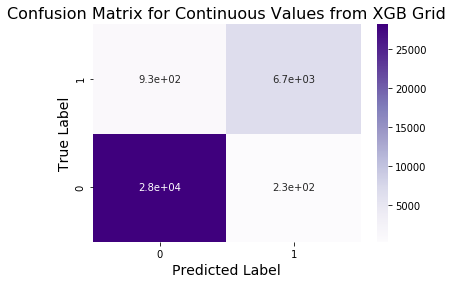

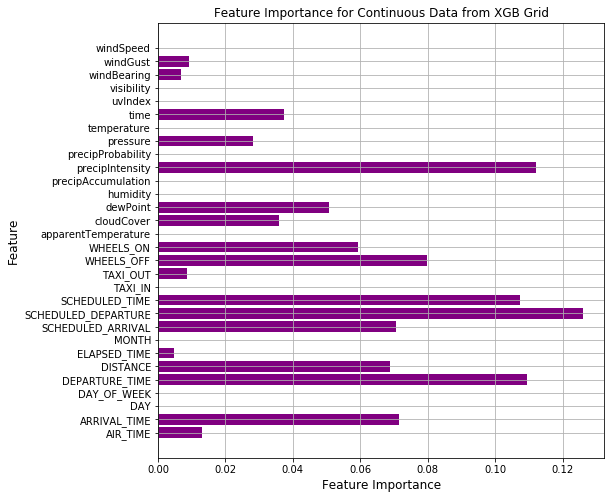

In [19]:
# XGB for continuous values

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds_xgb = clf_xgb.predict(X_train)
test_preds_xgb = clf_xgb.predict(X_test)

print('Training Recall Score, Default XGB: ', recall_score(y_train, training_preds_xgb))
print('Test Recall Score, Default XGB: ', recall_score(y_test, test_preds_xgb))
print('Training Precision Score, Default XGB: ', precision_score(y_train, training_preds_xgb))
print('Test Precision Score, Default XGB: ', precision_score(y_test, test_preds_xgb))
print('Training Accuracy Score, Default XGB: ', accuracy_score(y_train, training_preds_xgb))
print('Test Accuracy Score, Default XGB: ', accuracy_score(y_test, test_preds_xgb))
print('Training F1 Score, Default XGB: ', f1_score(y_train, training_preds_xgb))
print('Test F1 Score, Default XGB: ', f1_score(y_test, test_preds_xgb))




# XGB with paramgrid

xgb_param_grid = {'learning_rate':[0.8], 
              'max_depth': [2], 
              'min_child_weight':[16], 
              'subsample':[1]}

xgb_grid_clf = GridSearchCV(clf_xgb, xgb_param_grid, scoring = 'f1', cv = None, n_jobs = -1)
xgb_grid_clf.fit(num_cols_df, y)
xgb_best_parameters = xgb_grid_clf.best_params_
print('\n\nGrid seach found the following optimal parameters: ')
for param_name in sorted(xgb_best_parameters.keys()):
    print('%s:%r'%(param_name, xgb_best_parameters[param_name]))

training_preds_xgb_grid = xgb_grid_clf.predict(X_train)
test_preds_xgb_grid = xgb_grid_clf.predict(X_test)


print('\n\nTraining Recall Score, XGB Grid: ', recall_score(y_train, training_preds_xgb_grid))
print('Test Recall Score, XGB Grid: ', recall_score(y_test, test_preds_xgb_grid))
print('Training Precision Score, XGB Grid: ', precision_score(y_train, training_preds_xgb_grid))
print('Test Precision Score, XGB Grid: ', precision_score(y_test, test_preds_xgb_grid))
print('Training Accuracy Score, XGB Grid: ', accuracy_score(y_train, training_preds_xgb_grid))
print('Test Accuracy Score, XGB Grid: ', accuracy_score(y_test, test_preds_xgb_grid))
print('Training F1 Score, XGB Grid: ', f1_score(y_train, training_preds_xgb_grid))
print('Test F1 Score, XGB Grid: ', f1_score(y_test, test_preds_xgb_grid))

# confusion matrix for XGB grid parameters for continuous values

cnf_matrix = confusion_matrix(y_test, test_preds_xgb_grid)

ax = sns.heatmap(cnf_matrix, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for Continuous Values from XGB Grid', fontsize = 16)


# feature importance plot for continuous values

clf_xgb.feature_importances_
n_features = X_train.shape[1]
plt.figure(figsize = (8,8))
plt.barh(range(n_features), clf_xgb.feature_importances_,align = 'center', color = 'purple')
plt.yticks(np.arange(n_features), X_train.columns.values)
plt.xlabel('Feature Importance', fontsize = 'large')
plt.ylabel('Feature',fontsize = 'large')
plt.title('Feature Importance for Continuous Data from XGB Grid')
plt.grid(zorder=0)
plt.show()



### Random forest for continuous values within dataframe + confusion matrix + feature importance plot



Training Recall Score, Random Forest:  0.9871065769481224
Test Recall Score, Random Forest:  0.763736987745421
Training Precision Score, Random Forest:  0.999560400914366
Test Precision Score, Random Forest:  0.9572254335260115
Training Accuracy Score, Random Forest:  0.9971577495301491
Test Accuracy Score, Random Forest:  0.9430079155672824
Training F1 Score, Random Forest:  0.9932944542734203
Test F1 Score, Random Forest:  0.8496042216358839


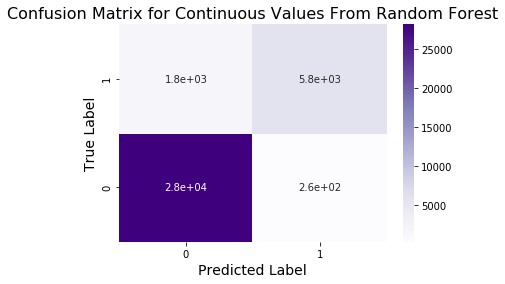

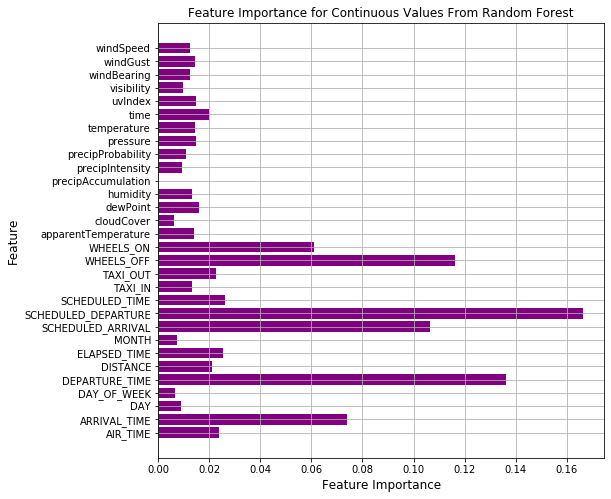

In [20]:
# Random forest for continuous values

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
training_preds_rf = forest.predict(X_train)
test_preds_rf = forest.predict(X_test)

print('\n\nTraining Recall Score, Random Forest: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, Random Forest: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, Random Forest: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, Random Forest: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, Random Forest: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, Random Forest: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, Random Forest: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, Random Forest: ', f1_score(y_test, test_preds_rf))


# confusion matrix for random forest continuous values 

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for Continuous Values From Random Forest', fontsize = 16)

# feature importance for random forest for continuous values

forest.feature_importances_
n_features = X_train.shape[1]
plt.figure(figsize = (8,8))
plt.barh(range(n_features), forest.feature_importances_,align = 'center', color = 'purple')
plt.yticks(np.arange(n_features), X_train.columns.values)
plt.xlabel('Feature Importance', fontsize = 'large')
plt.ylabel('Feature',fontsize = 'large')
plt.title('Feature Importance for Continuous Values From Random Forest')
plt.grid(zorder=0)
plt.show()

# for col,score in zip(X_train.columns,forest.feature_importances_):
#     print(col,score)


### checking for unique values within categorical columns

In [21]:
IAH_with_WEATHER[cat_cols_list].nunique()

summary                  22
icon                      7
DESTINATION_AIRPORT     119
TAIL_NUMBER            2431
AIRLINE                  10
FLIGHT_NUMBER          2550
dtype: int64

### onehotencoding cat_cols_df (except tail number, flight number), and joining cat_cols_df to num_cols_df + train_test_split

In [22]:
cat_cols_df = SAMPLE_SET[['summary', 'icon', 'DESTINATION_AIRPORT', 'AIRLINE']]
ohe = OneHotEncoder()
ohe.fit(cat_cols_df)
ohe_cat_cols = ohe.transform(cat_cols_df).toarray()
ohe_cat_cols_df = pd.DataFrame(ohe_cat_cols, columns = ohe.get_feature_names(cat_cols_df.columns))
df_complete = num_cols_df.join(ohe_cat_cols_df)


X_train, X_test, y_train, y_test = train_test_split(df_complete, y, test_size = 0.25,  random_state = 42)

### XGBoost for all values + param grid + confusion matrix
### param grid was optimized using a subset of 10K values 

Training Recall Score, Default XGB:  0.6588841722255913
Test Recall Score, Default XGB:  0.6528256832050942
Training Precision Score, Default XGB:  0.9876631387572236
Test Precision Score, Default XGB:  0.9832167832167832
Training Accuracy Score, Default XGB:  0.9253330617610843
Test Accuracy Score, Default XGB:  0.9249826412998194
Training F1 Score, Default XGB:  0.7904487229454101
Test F1 Score, Default XGB:  0.7846607669616519


Grid seach found the following optimal parameters: 
learning_rate:0.9
max_depth:4
min_child_weight:19
subsample:1


Training Recall Score, XGB Grid:  0.9773888937018106
Test Recall Score, XGB Grid:  0.9783762271159459
Training Precision Score, XGB Grid:  0.9896491228070176
Test Precision Score, XGB Grid:  0.9884733949872672
Training Accuracy Score, XGB Grid:  0.9929823262014758
Test Accuracy Score, XGB Grid:  0.9930842938480766
Training F1 Score, XGB Grid:  0.9834808002440832
Test F1 Score, XGB Grid:  0.9833988932595507


Text(0.5, 1, 'Confusion Matrix for All Values From XGB Grid')

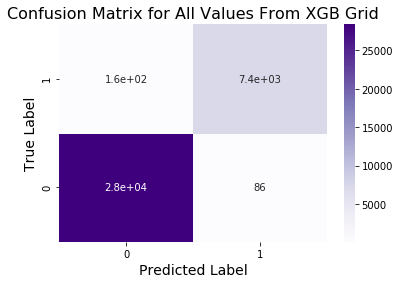

In [23]:
# XBG for all values

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds_xgb = clf_xgb.predict(X_train)
test_preds_xgb = clf_xgb.predict(X_test)

print('Training Recall Score, Default XGB: ', recall_score(y_train, training_preds_xgb))
print('Test Recall Score, Default XGB: ', recall_score(y_test, test_preds_xgb))
print('Training Precision Score, Default XGB: ', precision_score(y_train, training_preds_xgb))
print('Test Precision Score, Default XGB: ', precision_score(y_test, test_preds_xgb))
print('Training Accuracy Score, Default XGB: ', accuracy_score(y_train, training_preds_xgb))
print('Test Accuracy Score, Default XGB: ', accuracy_score(y_test, test_preds_xgb))
print('Training F1 Score, Default XGB: ', f1_score(y_train, training_preds_xgb))
print('Test F1 Score, Default XGB: ', f1_score(y_test, test_preds_xgb))

#XGB with grid for all values

xgb_param_grid = {'learning_rate':[0.9], 
              'max_depth': [4], 
              'min_child_weight':[19], 
              'subsample':[1]}

xgb_grid_clf = GridSearchCV(clf_xgb, xgb_param_grid, scoring = 'accuracy', cv = None, n_jobs = -1)
xgb_grid_clf.fit(df_complete, y)
xgb_best_parameters = xgb_grid_clf.best_params_
print('\n\nGrid seach found the following optimal parameters: ')
for param_name in sorted(xgb_best_parameters.keys()):
    print('%s:%r'%(param_name, xgb_best_parameters[param_name]))

training_preds_xgb_grid = xgb_grid_clf.predict(X_train)
test_preds_xgb_grid = xgb_grid_clf.predict(X_test)

print('\n\nTraining Recall Score, XGB Grid: ', recall_score(y_train, training_preds_xgb_grid))
print('Test Recall Score, XGB Grid: ', recall_score(y_test, test_preds_xgb_grid))
print('Training Precision Score, XGB Grid: ', precision_score(y_train, training_preds_xgb_grid))
print('Test Precision Score, XGB Grid: ', precision_score(y_test, test_preds_xgb_grid))
print('Training Accuracy Score, XGB Grid: ', accuracy_score(y_train, training_preds_xgb_grid))
print('Test Accuracy Score, XGB Grid: ', accuracy_score(y_test, test_preds_xgb_grid))
print('Training F1 Score, XGB Grid: ', f1_score(y_train, training_preds_xgb_grid))
print('Test F1 Score, XGB Grid: ', f1_score(y_test, test_preds_xgb_grid))


# confusion matrix for XGB grid parameters for all values 

cnf_matrix = confusion_matrix(y_test, test_preds_xgb_grid)

ax = sns.heatmap(cnf_matrix, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From XGB Grid', fontsize = 16)

### Random forest for all values + confusion matrix



Training Recall Score, Random Forest:  0.9666464523953912
Test Recall Score, Random Forest:  0.5311753780843725
Training Precision Score, Random Forest:  0.9996864220758859
Test Precision Score, Random Forest:  0.89937106918239
Training Accuracy Score, Random Forest:  0.99280642144927
Test Accuracy Score, Random Forest:  0.8894042494098042
Training F1 Score, Random Forest:  0.9828888546323415
Test F1 Score, Random Forest:  0.6678899082568808


Text(0.5, 1, 'Confusion Matrix for All Values From Random Forest')

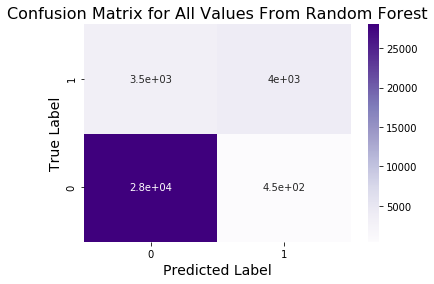

In [24]:
# Random forest for all values

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
training_preds_rf = forest.predict(X_train)
test_preds_rf = forest.predict(X_test)

# print(test_preds_rf[:100])
# print(y_test[:100])

print('\n\nTraining Recall Score, Random Forest: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, Random Forest: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, Random Forest: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, Random Forest: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, Random Forest: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, Random Forest: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, Random Forest: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, Random Forest: ', f1_score(y_test, test_preds_rf))


# confusion matrix for random forest for all values

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From Random Forest', fontsize = 16)


In [25]:
# example run, using XGBoost with grid search parameters (categorical and continuous data)

example_x = X_test.iloc[0:10,:]
example_y = y_test.iloc[0:10]


example_pred = xgb_grid_clf.predict(example_x)

print('Predictions: ', list(example_pred.astype('int')))
print('Actual: ', list(example_y.astype('int')))

Predictions:  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Actual:  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]


### Findings: The XGBoost with grid search (hyperparameters optimized with subset of 10K values), using the data containing both continuous and categorical data, performed the best overall according the F1 score. 